In [136]:
using LinearAlgebra
using Plots,ITensors
using SparseIR
using LaTeXStrings

ITensors.disable_warn_order()
println(ITensors.blas_get_num_threads())
newaxis = [CartesianIndex()]


8


1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

In [137]:
R = 12
N = 2^R
N_p = 100

function random_nonzero(ntrial::Int64)
    for _ in 1:ntrial   #ntrialの回数だけ中の処理を実行
        v = randn()
        if abs(v - 0.0) > 1e-8
            return v    #returnで値を返して処理を停止
        else
            continue    #continueで処理を続行
        end
    end
end

;

In [138]:
#"NaN" にならない指数関数の作成
_exp(x::Float64) = x < -100.0 ? 0 : exp(x)

#=
function _exp(x)
    if x < -100.0
        return 0.0
    else
        return exp(x)
    end
end
=#

_exp (generic function with 1 method)

$$
G(\tau) = -\sum_{i=1}^{N_p} \frac{\alpha_i e^{-\tau \omega_i}}{1+e^{-\beta \omega_i}}
$$

上式のグリーン関数の

$$
g = \frac{\alpha_i e^{-\tau \omega_i}}{1+e^{-\beta \omega_i}}
$$

$g$の部分で exp が発散した時、上式の値が適切な値になるよう場合分けした関数 $g$ を作成する

$$
g(\tau, \omega_i, \beta) = \frac{e^{-\tau \omega_i}}{1+e^{-\beta \omega_i}}　\ \ \ \ ( \omega \geq 0.0 )
$$
$$
g(\tau, \omega_i, \beta) = \frac{e^{\omega_i ( \beta - \tau ) }}{ e^{\beta \omega_i} + 1 }　\ \ \ \ ( \omega < 0.0 )
$$

In [139]:
#gの定義
g(τ::Float64, ω::Float64, β::Float64) = ω >= 0.0 ? (_exp(-τ * ω) / (1 + _exp(-β * ω))) : (_exp(ω * (β - τ))/(1 + _exp(β * ω)))

#=
function g(τ, ω, β, f)
    if ω >= 0.0
        return (f(-τ * ω) / (1 + f(-β * ω)))
    else
        return (f(ω * (β - τ)) / (1 + f(β * ω)))
    end
end
=#

g (generic function with 1 method)

$$
G(\tau, \omega_i, c_i, \beta) = -\sum_{i=1}^{N_p} \frac{c_i e^{-\tau \omega_i}}{1+e^{-\beta \omega_i}}
$$

In [140]:
#G(τ)の定義
function Gtau(τ::Float64, ω::Vector, c::Vector, β::Float64)
    result = 0.0
    for i in 1:N_p
        result += c[i] * g(τ, ω[i], β)
    end
    return result
end

#c_iの作成
cs_0 = zeros(Float64, N_p)
C = 0.0
for i in 1:N_p
    c = abs(random_nonzero(N_p))
    cs_0[i] = c
    C = C + c
end
cs = (1/C) .* cs_0

#ω_iの作成
ωs = zeros(Float64, N_p)
for i in 1:N_p
    ωs[i] = randn()
end

;

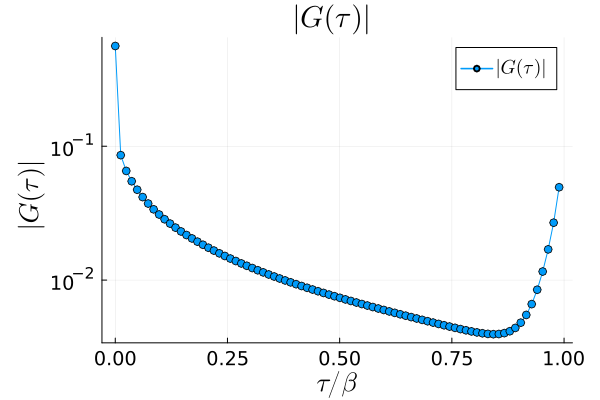

In [141]:
#G(τ)を1D Arrayに変換
β = 1000.0
τ = collect(range(0.0, β, length = N))
G_tau = [Gtau(t, ωs, cs, β) for t in τ]
#@show collect(G_tau)
#@assert collect(G_tau) == G_tau

Gtau_abs = abs.(G_tau)
#=
Gtau_abs = Float64[]
for k in 1:N
    ab = abs(G_tau[k])
    push!(Gtau_abs, ab)
end
=#

#|G(τ)|のplot
plot_abs = plot(
    yaxis =:log,
    titlefontsize = 20,
    legendfontsize = 13,
    tickfontsize = 13,
    guidefont = 18,
    markersize = 6,
    title = L"|G(\tau)|",
    xlabel = L"\tau/\beta",
    ylabel = L"|G(\tau)|",
    left_margin = 5Plots.mm,
    right_margin = 5Plots.mm
    )
step = 50
plot!(
    plot_abs,
    τ[1:step:end] ./ β,
    Gtau_abs[1:step:end],
    label = L"|G(\tau)|",
    marker=:o)

In [142]:
G_tau

4096-element Vector{Float64}:
 0.5606544123182376
 0.4715682543138444
 0.40358567320972216
 0.3510792607779738
 0.3100322046694508
 0.27755383794813837
 0.25154641174059117
 0.23047451346760417
 0.21320451869143803
 0.19889208307425765
 ⋮
 0.15799260132945317
 0.17161010084519002
 0.18802400343212058
 0.2081142346415062
 0.2331442295751068
 0.26498197796714223
 0.30647972902833487
 0.3621439579032479
 0.43934558768176235

In [143]:
#ボンド次元をプロットする場所を準備
gr(size=(600, 400))

plot_bonddim = plot(
    yaxis = :log10, 
    titlefontsize = 20,
    legendfontsize = 13,
    tickfontsize = 13,
    guidefont = 18,
    markersize = 6,
    legend = :topright,
    xticks = 1:1:R-1,
    yticks =([10^(0), 10^(1), 10^(2)]),
    ylims = (10^(0), 10^2),
    title = L"\mathrm{Bond~Dimension, \ cutoff = }10^{-20}",
    xlabel = L"\mathrm{Bond~b}",
    ylabel = L"\mathrm{Bond~Dimension}"
)


#β=1000.0

#厳密なMPSの作成
sitesx = [Index(2, "Qubit,x=$n") for n in 1:R]
tensor = ITensor(G_tau, reverse(sitesx))
M = MPS(tensor, sitesx)

#圧縮前のボンド次元をプロット
plot!(plot_bonddim, 
    linkdims(M),
    linestyle = :dash,
    label = "No compression")


#圧縮前のMPSをベクトルに変形
tensor_reconst = reduce(*, M)   
tmp = Array(tensor_reconst,  reverse(sitesx))
gtau_reconst = vec(tmp)

#cutoff=1e-20 で圧縮したMPSをベクトルに変形
M_compression = MPS(tensor, sitesx, cutoff = 1e-20)
tensor_compression_reconst = reduce(*, M_compression)
tmp_compression = Array(tensor_compression_reconst, reverse(sitesx))
gtau_compression_reconst = vec(tmp_compression)
;

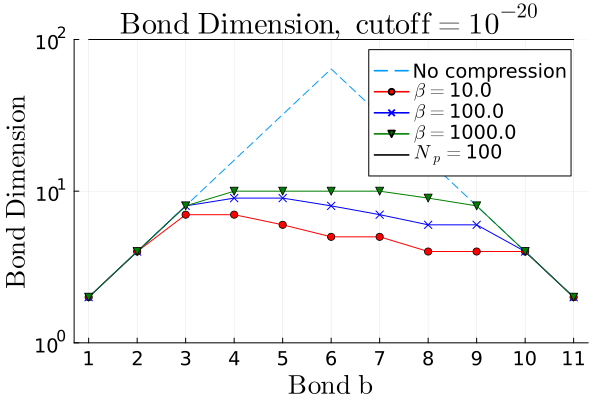

In [144]:
beta = [10.0, 100.0, 1000.0]
plot_color = ["red", "blue", "green"]
markershape = [:circle, :xcross, :dtriangle]

G_tau_all = Array{Array{Float64}}(undef, length(beta))

#各betaの値をプロット
for i in 1:length(beta)
    τ_beta = range(0.0, beta[i], length = N)
    G_tau_beta = [Gtau(t, ωs, cs, beta[i]) for t in τ_beta]
    sitesx = [Index(2, "Qubit,x=$n") for n in 1:R]
    tensor_comp = ITensor(G_tau_beta, reverse(sitesx))
    M_comp = MPS(tensor_comp, sitesx; cutoff = 1e-20)

    G_tau_all[i] = G_tau_beta
    
    plot!(
        plot_bonddim, 
        linkdims(M_comp),
        markershape = markershape[i],
        label = L"\beta="*string(beta[i]),
        color = plot_color[i]
    )
end

#N_pのプロット
x = 1.0:0.01:11.0
y = fill(100.0, length(x))
plot!(
    plot_bonddim,
    x, 
    y,
    label = L"N_p="*string(N_p),
    color = "black"
)

display(plot_bonddim)

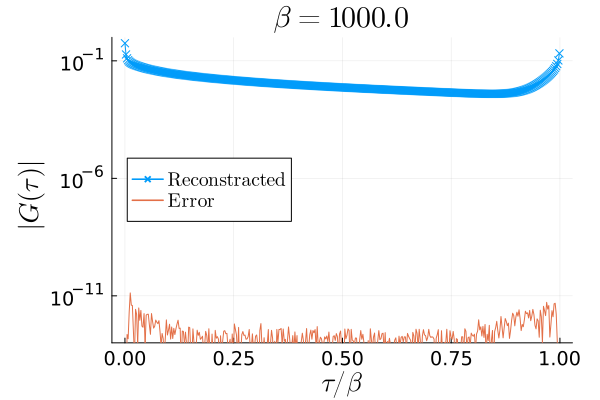

In [145]:
#誤差を格納した配列の作成
error = abs.(G_tau .- gtau_compression_reconst)

#誤差と再構築したG(τ)をプロットする場所を作成
plot_error = plot(
    yaxis =:log,
    yticks =([10^(-1), 10^(-6), 10^(-11)]),
    ylims = (10^(-13), 10^0),
    titlefont = font(20), 
    xtickfont = font(13), 
    ytickfont = font(13),
    legendfontsize = 13,
    xguidefont = 18,
    yguidefont = 18,
    markersize = 6,
    title = L"\mathrm{\beta = 1000.0}",
    xlabel = L"\tau / \beta",
    ylabel = L"|G(\tau)|",
    left_margin = 5Plots.mm,
    right_margin = 5Plots.mm, legend = :left
    )

#再構築したG(τ)のプロット
plot!(
    plot_error,
    τ[1:10:end] ./ β,
    gtau_compression_reconst[1:10:end],
    label = L"\mathrm{Reconstracted}",
    markershape = :xcross
)

#誤差のプロット
plot!(
  plot_error,
  τ[1:10:end] ./ β, 
  error[1:10:end], 
  label = L"\mathrm{Error}"
)

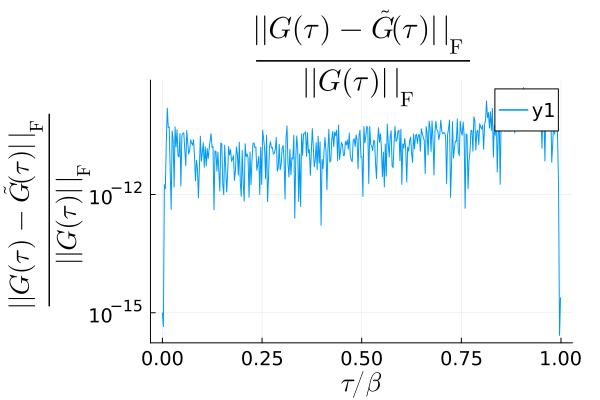

In [146]:
error_numerator = []
for i in 1:N
    error1 = 0.0
    error1 = sqrt((G_tau[i] - gtau_compression_reconst[i])^2)

    push!(error_numerator, error1)
end

error_denominator = []
for j in 1:N
    error2 = 0.0
    error2 = sqrt((G_tau[j])^2)

    push!(error_denominator, error2)
end

tmp_error = []
for k in 1:N
    error = 0.0
    error = (error_numerator[k])/(error_denominator[k])
    push!(tmp_error, error)
end

plot_tmp_error = plot(
    yaxis =:log,
    #yticks =([10^(-1), 10^(-6), 10^(-11)]),
    #ylims = (10^(-13), 10^0),
    titlefont = font(20), 
    xtickfont = font(13), 
    ytickfont = font(13),
    legendfontsize = 13,
    xguidefont = 18,
    yguidefont = 18,
    markersize = 6,
    title = L"\frac{||G(\tau) - \tilde{G}(\tau)|| _{\mathrm{F}}}{||G(\tau)||_{\mathrm{F}}}",
    xlabel = L"\tau / \beta",
    ylabel = L"\frac{||G(\tau) - \tilde{G}(\tau)|| _{\mathrm{F}}}{||G(\tau)||_{\mathrm{F}}}",
    left_margin = 5Plots.mm,
    right_margin = 5Plots.mm
    )

plot!(
    plot_tmp_error, 
    τ[1:10:end] ./ β, 
    tmp_error[1:10:end],
    )

In [147]:
#MPSを構成する各行列と特異値を作成する関数
function mps_12(g::Vector{Float64}, r::Int)

    #特異値分解した右特異ベクトルをreshapeして格納
    M = Array{Array{Float64}}(undef, r)
    #それぞれの特異値を格納
    S = Array{Vector{Float64}}(undef, r)
    #特異値分解した左特異ベクトルを格納
    V = Array{Array{Float64}}(undef, r)

    #特異値分解するときの分離するテンソルの左側の脚の次元
    p_left = Array{Int}(undef, r)
    for i in 0:r-1
        if i < (r+1)/2
            p_left[i+1] = i
        else
            p_left[i+1] = r-i
        end
    end

    #特異値分解するときの分離するテンソルの右側の脚の次元
    p_right = reverse(p_left)

    #特異値分解するときの分解するテンソルの左側の脚の次元
    p_big_left = Array{Int}(undef, r-1)
    for i in 1:r-1
        if i <= r/2+1
            p_big_left[i] = i
        else
            p_big_left[i] = r-i+2
        end
    end

    #特異値分解
    for i in 1:1:r
        if i == 1
            u, s, v = svd(Array(reshape(g, 2^1, 2^(12-1))))
            M[i] = u
            S[i] = s
            V[i] = v
        elseif i == r
            m = diagm(S[r-1]) * V[i-1]
            M[i] = m
        else
            u, s, v = svd(Array(reshape(diagm(S[i-1]) * V[i-1]', 2^p_big_left[i], 2^(12-i))))
            m = reshape(u, 2^p_left[i], 2, 2^p_right[i])
            M[i] = m
            S[i] = s
            V[i] = v
        end
    end

    return M, S
end

;

In [148]:
#MPSを組み立てる関数
#=
function mps_12_con(M::Array)
    return mps = ein"ab,bcd,def,fgh,hij,jkl,lmn,nop,pqr,rst,tuv,vw -> acegik"(M[1],M[2],M[3],M[4],M[5],M[6],M[7],M[8],M[9],M[10],M[11],M[12])
end
=#

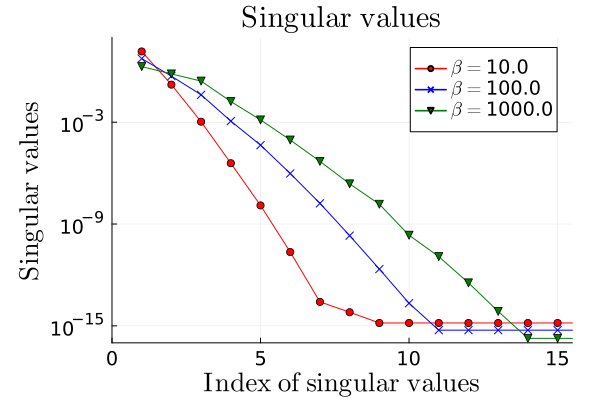

In [149]:
#beta = [10.0, 100.0, 1000.0]
#plot_color = ["red", "blue", "green"]
#markershape = [:circle, :xcross, :dtriangle]

#特異値をプロットする場所の作成
plot_singular_value_beta = plot(
  yaxis =:log,
  yticks =([10^(-3), 10^(-9), 10^(-15)]),
  ylims = (10^(-16), 10^2),
  xlims = (0.0, 15.5),
  title = L"\mathrm{Singular~values}",
  xlabel = L"\mathrm{Index~of~singular~values}",
  ylabel = L"\mathrm{Singular~values}",
  left_margin = 5Plots.mm,
  right_margin = 5Plots.mm,
  titlefontsize = 20,
  legendfontsize = 13,
  tickfontsize = 13,
  guidefont = 18,
  markersize = 6,
  )

#５番目の脚の特異値をプロット
for b in 1:length(beta)
  
    mps_beta, singular_value_beta = mps_12(G_tau_all[b], R)
    
    plot!(
      plot_singular_value_beta, 
      singular_value_beta[5], #５番目の特異値
      label = L"\beta = "*string(beta[b]), 
      markershape = markershape[b],
      color = plot_color[b]
      )

end

plot_singular_value_beta